In [1]:
# ---------- CONFIG ----------
CSV_PATH = 'embeddings/pd.csv'
TEXT_DIR = 'embeddings/text_embeddings_PD'
#IMG_DIR = 'embeddings/head_00'#first combined head 
#IMG_DIR = 'embeddings/head_01'#second combined head 
IMG_DIR = 'embeddings/head_01'
#IMG_DIR = 'embeddings/embeddings_fused'#fused embedding 

spect_dir = 'embeddings/spect_smoothed_embeddings'
mri_dir = 'embeddings/mri_embeddings'
OUTPUT_CSV = 'embeddings/labels_HY_filtered.csv'
PCA_PATH = 'embeddings/img_pca.joblib'
FLAT_DIR = 'embeddings/flattened' # flattened SAMMed3D
PCA_N_COMPONENTS = 1024 # reduce flattened vector to this size
PROJ_DIM = 256 # projection dimension for both modalities
BATCH_SIZE = 8
EPOCHS = 30
LR = 1e-4
NUM_CLASSES = 2 # H&Y 0-5
RANDOM_SEED = 42

## imports

In [2]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 23.3 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import IncrementalPCA
import joblib
from sklearn.model_selection import train_test_split
import random

In [4]:
# ---------- UTIL / SETUP ----------
def seed_all(seed=RANDOM_SEED):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


seed_all()

## load csv

In [5]:
# ---------- 1) Load CSV and filter IDs by .npy presence ----------
print('Loading CSV and filtering IDs...')
if not os.path.exists(CSV_PATH):
  raise FileNotFoundError(f'CSV not found: {CSV_PATH}')


df = pd.read_csv(CSV_PATH)
# Adjust column names below if different in your CSV
ID_COL = 'PATNO' if 'PATNO' in df.columns else ('ID' if 'ID' in df.columns else df.columns[0])
HY_COL = 'NHY' if 'NHY' in df.columns else ('HY' if 'HY' in df.columns else None)
if HY_COL is None:
  raise ValueError('Cannot find a Hoehn&Yahr column (NHY or HY). Update HY_COL variable')


# Keep only ID and HY
df = df[[ID_COL, HY_COL]].copy()
# normalize types
df[ID_COL] = df[ID_COL].astype(str)
# ensure HY numeric
df[HY_COL] = pd.to_numeric(df[HY_COL], errors='coerce')
df = df.dropna(subset=[HY_COL])
# convert HY to int within 0-5
df[HY_COL] = df[HY_COL].astype(int).clip(0,5)


# list .npy files present
text_files = [f for f in os.listdir(TEXT_DIR) if f.endswith('.npy')]
img_files = [f for f in os.listdir(IMG_DIR) if f.endswith('.npy')]
text_ids = set([os.path.splitext(f)[0] for f in text_files])
img_ids = set([os.path.splitext(f)[0] for f in img_files])
valid_ids = sorted(list(text_ids.intersection(img_ids)))
print(f'Found {len(text_ids)} text .npy, {len(img_ids)} img .npy, intersection {len(valid_ids)}')


# filter df to valid ids
df = df[df[ID_COL].isin(valid_ids)].copy()
print('After filtering CSV by available npys:', len(df))
# save filtered CSV
out_df = df.rename(columns={ID_COL:'id', HY_COL:'hy'})[['id','hy']]
out_df.to_csv(OUTPUT_CSV, index=False)
print('Saved filtered CSV:', OUTPUT_CSV)




Loading CSV and filtering IDs...
Found 1560 text .npy, 399 img .npy, intersection 212
After filtering CSV by available npys: 212
Saved filtered CSV: embeddings/labels_HY_filtered.csv


In [6]:
# ---------- 1) Load CSV and filter IDs by .npy presence ----------
print('Loading CSV and filtering IDs...')
if not os.path.exists(CSV_PATH):
  raise FileNotFoundError(f'CSV not found: {CSV_PATH}')


df = pd.read_csv(CSV_PATH)
# Adjust column names below if different in your CSV
ID_COL = 'PATNO' if 'PATNO' in df.columns else ('ID' if 'ID' in df.columns else df.columns[0])
MBRS_COL = 'MBRS' if 'MBRS' in df.columns else ('MBRS' if 'MBRS' in df.columns else None)
if MBRS_COL is None:
  raise ValueError('Cannot find a Hoehn&Yahr column (MBRS or MBRS). Update MBRS_COL variable')


# Keep only ID and MBRS
df = df[[ID_COL, MBRS_COL]].copy()
# normalize types
df[ID_COL] = df[ID_COL].astype(str)
# ensure MBRS numeric
df[MBRS_COL] = pd.to_numeric(df[MBRS_COL], errors='coerce')
df = df.dropna(subset=[MBRS_COL])

# convert MBRS to int within 0-5
def map_mbrs_to_3(x):
    if 0 <= x <= 7:
        return 0
    elif 8 <= x <= 15:
        return 1
    else:
        return 2

df['MBRS_COL'] = df[MBRS_COL].apply(map_mbrs_to_3)
print(df)

# list .npy files present
text_files = [f for f in os.listdir(TEXT_DIR) if f.endswith('.npy')]
img_files = [f for f in os.listdir(IMG_DIR) if f.endswith('.npy')]
text_ids = set([os.path.splitext(f)[0] for f in text_files])
img_ids = set([os.path.splitext(f)[0] for f in img_files])
valid_ids = sorted(list(text_ids.intersection(img_ids)))
print(f'Found {len(text_ids)} text .npy, {len(img_ids)} img .npy, intersection {len(valid_ids)}')


# filter df to valid ids
df = df[df[ID_COL].isin(valid_ids)].copy()
print('After filtering CSV by available npys:', len(df))
# save filtered CSV
out_df = df.rename(columns={ID_COL:'id', MBRS_COL:'MBRS'})[['id','MBRS_COL']]
out_df.to_csv(OUTPUT_CSV, index=False)
print('Saved filtered CSV:', OUTPUT_CSV)




Loading CSV and filtering IDs...
       PATNO  MBRS  MBRS_COL
0       3001  13.0         1
1       3002  14.0         1
2       3003   8.0         1
3       3005   0.0         0
4       3006  14.0         1
...      ...   ...       ...
1555  476236   3.0         0
1556  492876   6.0         0
1557  496671   1.0         0
1558  504436   4.0         0
1559  522583   2.0         0

[1560 rows x 3 columns]
Found 1560 text .npy, 399 img .npy, intersection 212
After filtering CSV by available npys: 212
Saved filtered CSV: embeddings/labels_HY_filtered.csv


In [7]:
print(out_df)

          id  MBRS_COL
4       3006         1
16      3027         0
23      3059         0
27      3066         0
31      3077         1
...      ...       ...
1464  296083         0
1474  302526         1
1476  302575         0
1507  318884         0
1510  319735         0

[212 rows x 2 columns]


## PCA

In [8]:
shapes = {}
for id_ in valid_ids:
    arr = np.load(os.path.join(IMG_DIR, id_ + ".npy"))
    shapes[id_] = arr.shape

#shapes


In [9]:
# ----------------------------------------------------
# Filtrar archivos .npy que NO tengan 2 volúmenes
# ----------------------------------------------------
valid_ids = []
bad_ids = []

for f in os.listdir(IMG_DIR):
    if not f.endswith(".npy"):
        continue
    id_ = os.path.splitext(f)[0]
    arr = np.load(os.path.join(IMG_DIR, f))
    #condición: queremos shape (2,48,32,32,32)
    print(arr.ndim)
    if arr.ndim ==3  and arr.shape[0] == 12:
        valid_ids.append(id_)
    else:
        bad_ids.append(id_)

print("IDs válidos:", len(valid_ids))
print("IDs eliminados por tener shape != (2,48,32,32,32):", len(bad_ids))
print("Ejemplo de eliminados:", bad_ids[:10])

# Filtrar el dataframe original
df = df[df[ID_COL].isin(valid_ids)].reset_index(drop=True)
print("Sujetos finales después del filtrado:", len(df))    
    

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
IDs válidos: 399
IDs eliminados por tener shape != (2,48,32,32,32): 0
Ejemplo de eliminados: []
Sujetos finales después del filtrado: 212


In [10]:
bad_ids

[]

In [11]:
print(arr.shape)

(12, 12, 64)


In [12]:
# ---------- CONFIG ----------
# PCA_N_COMPONENTS = 1024 # reduce flattened vector to this size (tuneable)
# --------------------------
PCA_N_COMPONENTS = min(PCA_N_COMPONENTS, len(valid_ids))
# ---------- 2) Fit IncrementalPCA on flattened image embeddings (if PCA not exists) ----------
# PCA is important because flattened vectors are huge; we reduce to PCA_N_COMPONENTS
import os
import numpy as np
import joblib
from sklearn.decomposition import IncrementalPCA
import torch
import torch.nn.functional as F

os.makedirs(FLAT_DIR, exist_ok=True)
DOWNSAMPLE_SIZE = (16, 16, 16)
# ======================================


# --------------------------
# Función para downsamplear un embedding 3D pesado
# --------------------------
def downsample_3d(arr):
    # arr viene como (2, D, H, W)

    # si tiene 5 dimensiones, combina los 2 volúmenes
    if arr.ndim == 5 and arr.shape[0] == 2:
        arr = arr.mean(axis=0)   # ---> (48,32,32,32)

    # si aún tiene 4 dimensiones, eliminar ejes extra si son 1 o canal
    if arr.ndim == 4:
        # caso típico (D,H,W,C) o (C,D,H,W)
        if arr.shape[0] not in [32,48]:  # entonces es canal
            arr = arr[0]
        else:
            arr = arr[...,0]  # último canal

    # ahora debe ser 3D
    if arr.ndim != 3:
        raise ValueError(f"Se esperaba un 3D, llegó: {arr.shape}")

    # downsample con PyTorch
    t = torch.from_numpy(arr).float().unsqueeze(0).unsqueeze(0)  # (1,1,D,H,W)
    t_ds = F.interpolate(t, size=(16,16,16), mode="trilinear", align_corners=False)
    return t_ds.squeeze().numpy()


# ============================================================
#          1) GENERAR ARCHIVOS MEMMAP (uno por ID)
# ============================================================
print("=== Paso 1/3: Generando memmaps downsampleados ===")

for id_ in valid_ids:
    npy_path = os.path.join(IMG_DIR, id_ + ".npy")
    if not os.path.exists(npy_path):
        print("No existe:", npy_path)
        continue

    # cargar sin ocupar RAM
    arr = np.load(npy_path, mmap_mode="r")
    flat = downsample_3d(arr)

    mm_path = os.path.join(FLAT_DIR, id_ + ".dat")

    # guardar como memmap
    fp = np.memmap(mm_path, dtype="float32", mode="w+", shape=flat.shape)
    fp[:] = flat[:]
    del fp  # liberar
print("Listo memmaps.")


# ============================================================
#           2) AJUSTAR INCREMENTAL PCA SOBRE MEMMAPS
# ============================================================
# if os.path.exists(PCA_PATH):
#     print("Cargando PCA existente:", PCA_PATH)
#     pca = joblib.load(PCA_PATH)
# else:
print("=== Paso 2/3: Entrenando IncrementalPCA ===")

pca = IncrementalPCA(n_components=PCA_N_COMPONENTS)
files = sorted(os.listdir(FLAT_DIR))
batch_size = 1024   # pequeño = no explota Colab

for i in range(0, len(files), batch_size):
    batch_files = files[i:i+batch_size]
    mats = []

    for f in batch_files:
        fp = np.memmap(os.path.join(FLAT_DIR, f), dtype="float32", mode="r")
        mats.append(np.array(fp))

    X = np.stack(mats)
    pca.partial_fit(X)

    print(f"PCA parcial: {i+len(batch_files)}/{len(files)}")

joblib.dump(pca, PCA_PATH)
print("PCA guardado en", PCA_PATH)


# ============================================================
#      3) Función para transformar un embedding con PCA
# ============================================================
def img_flatten_and_pca(path, pca_obj):
    arr = np.load(path, mmap_mode="r")
    flat = downsample_3d(arr)
    vec = pca_obj.transform(flat.reshape(1, -1))
    return vec.ravel().astype("float32")


print("=== PCA LISTO ===")


=== Paso 1/3: Generando memmaps downsampleados ===
Listo memmaps.
=== Paso 2/3: Entrenando IncrementalPCA ===


/tmp/ipykernel_24/2062372059.py:42: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  t = torch.from_numpy(arr).float().unsqueeze(0).unsqueeze(0)  # (1,1,D,H,W)


PCA parcial: 781/781
PCA guardado en embeddings/img_pca.joblib
=== PCA LISTO ===


In [12]:
print(out_df)
inference_df = out_df[out_df["MBRS_COL"] == 2]
out_df = out_df[out_df["MBRS_COL"] != 2]
print(out_df)
print(inference_df)

          id  MBRS_COL
4       3006         1
16      3027         0
23      3059         0
27      3066         0
31      3077         1
...      ...       ...
1464  296083         0
1474  302526         1
1476  302575         0
1507  318884         0
1510  319735         0

[212 rows x 2 columns]
          id  MBRS_COL
4       3006         1
16      3027         0
23      3059         0
27      3066         0
31      3077         1
...      ...       ...
1464  296083         0
1474  302526         1
1476  302575         0
1507  318884         0
1510  319735         0

[205 rows x 2 columns]
          id  MBRS_COL
77      3180         2
206     3461         2
295     3664         2
535    40731         2
1196  194971         2
1213  211045         2
1358  250149         2


## Dataset and dataloader

In [61]:
out_df.to_csv("mri_ids.csv", index=False)


In [62]:
class PDFlattenedDataset(Dataset):
  def __init__(self, csv_path, text_dir, flat_dir, pca_obj=None, transform=None):
    self.df = pd.read_csv(csv_path)
    self.text_dir = text_dir
    self.flat_dir = flat_dir
    self.pca = pca_obj
    self.transform = transform


  def __len__(self):
    return len(self.df)


  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    id_ = str(row['id'])
    MBRS = int(row['MBRS_COL'])


    text_emb = np.load(os.path.join(self.text_dir, id_ + '.npy')).astype(np.float32)
    mm_path = os.path.join(self.flat_dir, id_ + ".dat")
    arr = np.memmap(mm_path, dtype='float32', mode='r')

    # apply PCA
    img_vec = self.pca.transform(arr.reshape(1, -1)).ravel().astype("float32")


    # convert to tensors
    txt_t = torch.tensor(text_emb, dtype=torch.float32)
    img_t = torch.tensor(img_vec, dtype=torch.float32)
    label = torch.tensor(MBRS, dtype=torch.long)


    return txt_t, img_t, label

#
out_df = out_df[~out_df['id'].isin(bad_ids)].reset_index(drop=True)


# split train/val/test
train_df, test_df = train_test_split(out_df, test_size=0.2, stratify=out_df['MBRS_COL'], random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_df, test_size=0.125, stratify=train_df['MBRS_COL'], random_state=RANDOM_SEED)
# results: train 70%, val 10%, test 20%
train_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'train_labels.csv')
val_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'val_labels.csv')
test_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'test_labels.csv')
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)
test_df.to_csv(test_csv, index=False)
print('Split saved:', train_csv, val_csv, test_csv)


train_ds = PDFlattenedDataset(train_csv, TEXT_DIR, FLAT_DIR, pca)
val_ds = PDFlattenedDataset(val_csv, TEXT_DIR, FLAT_DIR, pca)
test_ds = PDFlattenedDataset(test_csv, TEXT_DIR, FLAT_DIR, pca)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Split saved: embeddings/train_labels.csv embeddings/val_labels.csv embeddings/test_labels.csv


In [63]:
# ---------- 4) Model definition ----------
class FusionFC(nn.Module):
  def __init__(self, text_dim, img_dim, proj_dim=PROJ_DIM, num_classes=NUM_CLASSES):
    super().__init__()
    self.text_proj = nn.Sequential(
    nn.Linear(text_dim, proj_dim),
    nn.ReLU(),
    nn.LayerNorm(proj_dim)
    )
    self.img_proj = nn.Sequential(
    nn.Linear(img_dim, proj_dim),
    nn.ReLU(),
    nn.LayerNorm(proj_dim)
    )
    self.classifier = nn.Sequential(
    nn.Linear(proj_dim*2, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
    )


  def forward(self, txt, img):
    zt = self.text_proj(txt)
    zi = self.img_proj(img)
    fused = torch.cat([zt, zi], dim=1)
    return self.classifier(fused), zt, zi

In [64]:
# obtain dims from sample
sample_txt = np.load(os.path.join(TEXT_DIR, valid_ids[0] + '.npy')).astype(np.float32)
sample_img_flat = np.load(os.path.join(IMG_DIR, valid_ids[0] + '.npy'))
if sample_img_flat.ndim > 1 and sample_img_flat.shape[0] == 1:
  sample_img_flat = sample_img_flat[0]
sample_img_flat = sample_img_flat.flatten().astype(np.float32)


text_dim = sample_txt.shape[0]
img_dim = pca.n_components_ if hasattr(pca, 'n_components_') else PCA_N_COMPONENTS
print('text_dim', text_dim, 'img_dim (after PCA)', img_dim)

MRI_DIM=img_dim
SPECT_DIM=MRI_DIM

FileNotFoundError: [Errno 2] No such file or directory: 'embeddings/text_embeddings_PD/101747.npy'

## training

In [20]:
# ---------- 5) Training loop (contrastive + classification optional) ----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FusionFC(text_dim=text_dim, img_dim=img_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()


# optional: use contrastive loss too (weighted)
use_contrastive = True
contrastive_weight = 0.5


def contrastive_loss(zt, zi, temperature=0.07):
  logits = (zt @ zi.t()) / temperature
  labels = torch.arange(logits.size(0), device=logits.device)
  loss_t = F.cross_entropy(logits, labels)
  loss_i = F.cross_entropy(logits.t(), labels)
  return (loss_t + loss_i) / 2


# training
best_val = 1e9
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  total_acc = 0
  count = 0
  for txt, img, y in train_loader:
    txt = txt.to(device); img = img.to(device); y = y.to(device)
    optimizer.zero_grad()
    logits, zt, zi = model(txt, img)
    loss_cls = criterion(logits, y)
    if use_contrastive:
      loss_ctr = contrastive_loss(zt, zi)
      loss = (1-contrastive_weight)*loss_cls + contrastive_weight*loss_ctr
    else:
      loss = loss_cls
    loss.backward()
    optimizer.step()


    total_loss += loss.item() * txt.size(0)
    preds = logits.argmax(dim=1)
    total_acc += (preds == y).sum().item()
    count += txt.size(0)


  train_loss = total_loss / count
  train_acc = total_acc / count


  # validation
  model.eval()
  val_loss = 0
  val_acc = 0
  vcount = 0
  with torch.no_grad():
    for txt, img, y in val_loader:
      txt = txt.to(device); img = img.to(device); y = y.to(device)
      logits, zt, zi = model(txt, img)
      loss_cls = criterion(logits, y)
      if use_contrastive:
        loss_ctr = contrastive_loss(zt, zi)
        loss = (1-contrastive_weight)*loss_cls + contrastive_weight*loss_ctr
      else:
        loss = loss_cls
      val_loss += loss.item() * txt.size(0)
      preds = logits.argmax(dim=1)
      val_acc += (preds == y).sum().item()
      vcount += txt.size(0)


  val_loss = val_loss / vcount
  val_acc = val_acc / vcount


  print(f'Epoch {epoch+1}/{EPOCHS} | train_loss {train_loss:.4f} acc {train_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f}')


  if val_loss < best_val:
    best_val = val_loss
    torch.save(model.state_dict(), os.path.join(os.path.dirname(OUTPUT_CSV), 'best_model.pt'))
    print('Saved best model')

Epoch 1/30 | train_loss 24.6461 acc 0.6311 | val_loss 23.1226 acc 0.6667
Saved best model
Epoch 2/30 | train_loss 18.1423 acc 0.6393 | val_loss 25.5070 acc 0.6667
Epoch 3/30 | train_loss 14.1994 acc 0.6066 | val_loss 17.2343 acc 0.6667
Saved best model
Epoch 4/30 | train_loss 11.1646 acc 0.6475 | val_loss 14.7598 acc 0.6667
Saved best model
Epoch 5/30 | train_loss 9.7399 acc 0.6311 | val_loss 12.5662 acc 0.6667
Saved best model
Epoch 6/30 | train_loss 7.2459 acc 0.6311 | val_loss 12.6193 acc 0.6667
Epoch 7/30 | train_loss 7.8139 acc 0.6393 | val_loss 11.9814 acc 0.6667
Saved best model
Epoch 8/30 | train_loss 6.3313 acc 0.6475 | val_loss 10.9296 acc 0.6667
Saved best model
Epoch 9/30 | train_loss 5.9382 acc 0.6475 | val_loss 10.0362 acc 0.6667
Saved best model
Epoch 10/30 | train_loss 4.8557 acc 0.6885 | val_loss 9.5234 acc 0.6111
Saved best model
Epoch 11/30 | train_loss 4.5833 acc 0.6803 | val_loss 8.9759 acc 0.6667
Saved best model
Epoch 12/30 | train_loss 4.4161 acc 0.6639 | val_lo

## Testing

In [21]:
model.load_state_dict(torch.load(os.path.join(os.path.dirname(OUTPUT_CSV), 'best_model.pt')))
model.eval()
from sklearn.metrics import classification_report, confusion_matrix
all_y = []
all_p = []
with torch.no_grad():
  for txt, img, y in test_loader:
    txt = txt.to(device); img = img.to(device)
    logits, zt, zi = model(txt, img)
    preds = logits.argmax(dim=1).cpu().numpy().tolist()
    all_p.extend(preds)
    all_y.extend(y.numpy().tolist())


print('Classification report (test):')
print(classification_report(all_y, all_p, digits=4))
print('Confusion matrix:')
print(confusion_matrix(all_y, all_p))


# Save PCA and model artifacts
joblib.dump(pca, PCA_PATH)
print('PCA & model saved to drive')

Classification report (test):
              precision    recall  f1-score   support

           0     0.5938    0.8636    0.7037        22
           1     0.0000    0.0000    0.0000        13

    accuracy                         0.5429        35
   macro avg     0.2969    0.4318    0.3519        35
weighted avg     0.3732    0.5429    0.4423        35

Confusion matrix:
[[19  3]
 [13  0]]
PCA & model saved to drive


In [22]:
out_df['MBRS_COL'].value_counts()


MBRS_COL
0    112
1     63
Name: count, dtype: int64

## Supervised Contrastive Learning (SCL)

In [23]:
def supervised_contrastive_loss(features, labels, temperature=0.07, eps=1e-8):
    """
    features: tensor (B, D) - embeddings (ej: fused o (zt+zi)/2)
    labels: tensor (B,)
    """
    device = features.device
    features = F.normalize(features, dim=1)  # (B, D)
    batch_size = features.shape[0]

    # similarity matrix
    sim = torch.matmul(features, features.T) / temperature  # (B,B)

    # mask for positives (same class), excluding diagonal
    labels = labels.contiguous().view(-1,1)
    mask_pos = torch.eq(labels, labels.T).float().to(device)
    mask_self = torch.eye(batch_size, dtype=torch.float32, device=device)
    mask_pos = mask_pos * (1.0 - mask_self)

    # For numerical stability: subtract max
    logits_max, _ = torch.max(sim, dim=1, keepdim=True)
    sim_exp = torch.exp(sim - logits_max.detach())

    # Denominator: sum over all except self
    denom = torch.sum(sim_exp * (1.0 - mask_self), dim=1, keepdim=True) + eps
    log_prob = (sim - logits_max) - torch.log(denom)

    # For each anchor i, average log_prob over positive indices
    numerator = (mask_pos * log_prob).sum(dim=1)
    positive_count = mask_pos.sum(dim=1)
    # avoid division by zero for anchors with no positives in batch
    mean_log_prob_pos = numerator / (positive_count + (positive_count==0).float())

    # only consider anchors that have positive_count>0
    valid_idx = (positive_count > 0).float()
    if valid_idx.sum() == 0:
        return torch.tensor(0.0, device=device, requires_grad=True)

    loss = - (mean_log_prob_pos * valid_idx).sum() / valid_idx.sum()
    return loss

In [24]:
EPOCHS = 100

In [25]:
# ---------------- Training loop (SCL + CE) ----------------
scl_weight = 0.3          # hyper: 0.1-0.5 typical
temperature = 0.07

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss() # optional class weights
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for txt, img, y in train_loader:
        txt = txt.to(device); img = img.to(device); y = y.to(device)

        optimizer.zero_grad()
        logits, zt, zi = model(txt, img)

        # choose features for SCL: fused or average of zt & zi
        # fused example:
        # fused = torch.cat([zt, zi], dim=1)   # but SCL expects consistent D
        # simpler: use average of projections (assumes zt, zi have same dim)
        features = (F.normalize(zt, dim=1) + F.normalize(zi, dim=1)) / 2.0

        loss_ce = criterion(logits, y)
        loss_scl = supervised_contrastive_loss(features, y, temperature=temperature)

        loss = (1.0 - scl_weight) * loss_ce + scl_weight * loss_scl
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * txt.size(0)

    print(f"Epoch {epoch+1} train_loss {(total_loss/len(train_loader.dataset)):.4f}")


Epoch 1 train_loss 0.9786
Epoch 2 train_loss 0.9478
Epoch 3 train_loss 0.9401
Epoch 4 train_loss 0.9288
Epoch 5 train_loss 0.9001
Epoch 6 train_loss 0.9213
Epoch 7 train_loss 0.8949
Epoch 8 train_loss 0.8609
Epoch 9 train_loss 0.8450
Epoch 10 train_loss 0.8473
Epoch 11 train_loss 0.8191
Epoch 12 train_loss 0.7818
Epoch 13 train_loss 0.7877
Epoch 14 train_loss 0.7467
Epoch 15 train_loss 0.7665
Epoch 16 train_loss 0.7332
Epoch 17 train_loss 0.7164
Epoch 18 train_loss 0.6783
Epoch 19 train_loss 0.6673
Epoch 20 train_loss 0.6556
Epoch 21 train_loss 0.6398
Epoch 22 train_loss 0.6352
Epoch 23 train_loss 0.6453
Epoch 24 train_loss 0.6266
Epoch 25 train_loss 0.6081
Epoch 26 train_loss 0.5952
Epoch 27 train_loss 0.5896
Epoch 28 train_loss 0.5835
Epoch 29 train_loss 0.5813
Epoch 30 train_loss 0.5819
Epoch 31 train_loss 0.5715
Epoch 32 train_loss 0.5543
Epoch 33 train_loss 0.5431
Epoch 34 train_loss 0.5441
Epoch 35 train_loss 0.5537
Epoch 36 train_loss 0.5173
Epoch 37 train_loss 0.5387
Epoch 38 t

In [26]:
# checkpoint = torch.load("modelo_mri_pesos.pth", map_location=device)
# model.load_state_dict(checkpoint)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
all_y = []
all_p = []
with torch.no_grad():
  for txt, img, y in test_loader:
    txt = txt.to(device); img = img.to(device)
    logits, zt, zi = model(txt, img)
    preds = logits.argmax(dim=1).cpu().numpy().tolist()
    all_p.extend(preds)
    all_y.extend(y.numpy().tolist())


print('Classification report (test):')
print(classification_report(all_y, all_p, digits=4))
print('Confusion matrix:')
print(confusion_matrix(all_y, all_p))


# Save PCA and model artifacts
joblib.dump(pca, PCA_PATH)
print('PCA & model saved to drive')

Classification report (test):
              precision    recall  f1-score   support

           0     0.6522    0.6818    0.6667        22
           1     0.4167    0.3846    0.4000        13

    accuracy                         0.5714        35
   macro avg     0.5344    0.5332    0.5333        35
weighted avg     0.5647    0.5714    0.5676        35

Confusion matrix:
[[15  7]
 [ 8  5]]
PCA & model saved to drive


In [28]:
all_probs = []
all_preds = []
all_y = []

with torch.no_grad():
    for txt, img, y in test_loader:
        txt = txt.to(device)
        img = img.to(device)

        logits, zt, zi = model(txt, img)

        probs = F.softmax(logits, dim=1)  # (batch_size, num_classes)
        preds = probs.argmax(dim=1)

        all_probs.append(probs.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_y.extend(y.numpy())


In [159]:
#torch.save(model.state_dict(), "modelo_spect_pesos.pth")

## Inference advanced cases

In [13]:
class PDFlattenedDataset(Dataset):
  def __init__(self, csv_path, text_dir, flat_dir, pca_obj=None, transform=None):
    self.df = pd.read_csv(csv_path)
    self.text_dir = text_dir
    self.flat_dir = flat_dir
    self.pca = pca_obj
    self.transform = transform


  def __len__(self):
    return len(self.df)


  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    id_ = str(row['id'])
    MBRS = int(row['MBRS_COL'])


    text_emb = np.load(os.path.join(self.text_dir, id_ + '.npy')).astype(np.float32)
    mm_path = os.path.join(self.flat_dir, id_ + ".dat")
    arr = np.memmap(mm_path, dtype='float32', mode='r')

    # apply PCA
    img_vec = self.pca.transform(arr.reshape(1, -1)).ravel().astype("float32")


    # convert to tensors
    txt_t = torch.tensor(text_emb, dtype=torch.float32)
    img_t = torch.tensor(img_vec, dtype=torch.float32)
    label = torch.tensor(MBRS, dtype=torch.long)


    return txt_t, img_t, label

#
inference_df = inference_df[~inference_df['id'].isin(bad_ids)].reset_index(drop=True)


# # split train/val/test
# train_df, test_df = train_test_split(out_df, test_size=0.2, stratify=out_df['MBRS_COL'], random_state=RANDOM_SEED)
# train_df, val_df = train_test_split(train_df, test_size=0.125, stratify=train_df['MBRS_COL'], random_state=RANDOM_SEED)
# # results: train 70%, val 10%, test 20%
# train_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'train_labels.csv')
# val_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'val_labels.csv')
# test_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'test_labels.csv')
# train_df.to_csv(train_csv, index=False)
# val_df.to_csv(val_csv, index=False)
# test_df.to_csv(test_csv, index=False)
# print('Split saved:', train_csv, val_csv, test_csv)

inference_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'inference_labels.csv')
inference_df.to_csv(inference_csv, index=False)

inference_ds = PDFlattenedDataset(inference_csv, TEXT_DIR, FLAT_DIR, pca)
# val_ds = PDFlattenedDataset(val_csv, TEXT_DIR, FLAT_DIR, pca)
# test_ds = PDFlattenedDataset(test_csv, TEXT_DIR, FLAT_DIR, pca)


inference_loader = DataLoader(inference_ds, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

NameError: name 'pca' is not defined

In [128]:
inference_loader = DataLoader(
    inference_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [129]:
checkpoint = torch.load("modelo_spect_pesos.pth", map_location=device)
model.load_state_dict(checkpoint)

RuntimeError: Error(s) in loading state_dict for FusionFC:
	size mismatch for img_proj.0.weight: copying a param with shape torch.Size([256, 398]) from checkpoint, the shape in current model is torch.Size([256, 189]).

In [ ]:
import torch.nn.functional as F

model.eval()

all_probs = []
all_preds = []

with torch.no_grad():
    for txt, img, _ in inference_loader:
        txt = txt.to(device)
        img = img.to(device)

        logits, _, _ = model(txt, img)

        probs = F.softmax(logits, dim=1)   # (B, num_classes)
        preds = torch.argmax(probs, dim=1)

        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs)   # (N, C)
all_preds = torch.cat(all_preds)   # (N,)


In [62]:
probs_percent = all_probs.numpy() * 100
infer_df = pd.read_csv(inference_csv)

for c in range(probs_percent.shape[1]):
    infer_df[f"prob_class_{c}_pct"] = probs_percent[:, c]

infer_df["pred_class"] = all_preds.numpy()

infer_df.to_csv("inference_probabilities_spect.csv", index=False)


## MRI+SPECT

In [14]:
def detect_modalities(mri_dir, spect_dir):
    has_mri = set(f.split('.')[0] for f in os.listdir(mri_dir) if f.endswith('.npy'))
    has_spect = set(f.split('.')[0] for f in os.listdir(spect_dir) if f.endswith('.npy'))

    only_mri = sorted(has_mri - has_spect)
    only_spect = sorted(has_spect - has_mri)
    both = sorted(has_mri & has_spect)

    return only_mri, only_spect, both
print("done")


done


In [15]:
class MultimodalEmbeddingDataset(Dataset):
    def __init__(self, df, clinical_dir, mri_dir, spect_dir):
        self.df = df.reset_index(drop=True)
        self.clinical_dir = clinical_dir
        self.mri_dir = mri_dir
        self.spect_dir = spect_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid = str(row["PATNO"])

        y = torch.tensor(row["MBRS_COL"], dtype=torch.long)

        # ---- Clinical (siempre)
        clinical = torch.tensor(
            np.load(os.path.join(self.clinical_dir, pid + ".npy")),
            dtype=torch.float32
        )

        # ---- MRI
        mri_path = os.path.join(self.mri_dir, pid + ".npy")
        if os.path.exists(mri_path):
            mri = torch.tensor(np.load(mri_path), dtype=torch.float32)
            mri_mask = 1
        else:
            mri = torch.zeros(MRI_DIM)
            mri_mask = 0

        # ---- SPECT
        spect_path = os.path.join(self.spect_dir, pid + ".npy")
        if os.path.exists(spect_path):
            spect = torch.tensor(np.load(spect_path), dtype=torch.float32)
            spect_mask = 1
        else:
            spect = torch.zeros(SPECT_DIM)
            spect_mask = 0

        mask = torch.tensor([mri_mask, spect_mask], dtype=torch.float32)

        return clinical, mri, spect, mask, y



In [16]:
class FusionFC(nn.Module):
    def __init__(self, text_dim, img_dim, proj_dim=PROJ_DIM, num_classes=NUM_CLASSES):
        super().__init__()

        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, proj_dim),
            nn.ReLU(),
            nn.LayerNorm(proj_dim)
        )

        self.img_proj = nn.Sequential(
            nn.Linear(img_dim, proj_dim),
            nn.ReLU(),
            nn.LayerNorm(proj_dim)
        )

        #tokens para modalidad ausente
        self.text_missing = nn.Parameter(torch.zeros(1, proj_dim))
        self.img_missing  = nn.Parameter(torch.zeros(1, proj_dim))

        self.classifier = nn.Sequential(
            nn.Linear(proj_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, txt, img):
        batch_size = None

        # ---------- TEXT ----------
        if txt is None:
            batch_size = img.size(0)
            zt = self.text_missing.expand(batch_size, -1)
        else:
            zt = self.text_proj(txt)
            batch_size = txt.size(0)

        # ---------- IMAGE ----------
        if img is None:
            zi = self.img_missing.expand(batch_size, -1)
        else:
            zi = self.img_proj(img)

        fused = torch.cat([zt, zi], dim=1)
        logits = self.classifier(fused)

        return logits, zt, zi


In [17]:
MRI_PCA_DIR   = "embeddings/mri_pca_embeddings"
SPECT_PCA_DIR = "embeddings/spect_pca_embeddings"

os.makedirs(MRI_PCA_DIR, exist_ok=True)
os.makedirs(SPECT_PCA_DIR, exist_ok=True)

pca = joblib.load(PCA_PATH)

for id_ in valid_ids:
    # ---- MRI ----
    mri_src = os.path.join(mri_dir, id_ + ".npy")
    if os.path.exists(mri_src):
        vec = img_flatten_and_pca(mri_src, pca)
        np.save(os.path.join(MRI_PCA_DIR, id_ + ".npy"), vec)

    # ---- SPECT ----
    spect_src = os.path.join(spect_dir, id_ + ".npy")
    if os.path.exists(spect_src):
        vec = img_flatten_and_pca(spect_src, pca)
        np.save(os.path.join(SPECT_PCA_DIR, id_ + ".npy"), vec)


In [18]:
mri_dir   = MRI_PCA_DIR
spect_dir = SPECT_PCA_DIR
df = df[df["MBRS_COL"].isin([0, 1])].reset_index(drop=True)


In [19]:
only_mri, only_spect, both = detect_modalities(mri_dir,spect_dir)

train_ids = set(only_mri) | set(only_spect)
print(df)
train_df = df[df["PATNO"].isin(train_ids)]


train_loader = DataLoader(
    MultimodalEmbeddingDataset(
        train_df,
        TEXT_DIR,
        mri_dir,
        spect_dir,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)


      PATNO  MBRS  MBRS_COL
0      3006  14.0         1
1      3027   5.0         0
2      3059   4.0         0
3      3066   3.0         0
4      3077  10.0         1
..      ...   ...       ...
200  296083   5.0         0
201  302526  15.0         1
202  302575   5.0         0
203  318884   5.0         0
204  319735   6.0         0

[205 rows x 3 columns]


In [20]:
test_loader_both = DataLoader(
    MultimodalEmbeddingDataset(
        df[df["PATNO"].isin(both)],
        TEXT_DIR,
        mri_dir,
        spect_dir,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [30]:
print(df[df["PATNO"].isin(both)])

    PATNO  MBRS  MBRS_COL
63  40533   6.0         0


In [21]:
torch.cuda.empty_cache()


In [25]:
# ---------------- Training loop (SCL + CE) ----------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FusionFC(text_dim=text_dim, img_dim=img_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

scl_weight = 0.3          # hyper: 0.1-0.5 typical
temperature = 0.07

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss() # optional class weights
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for clinical, mri, spect, mask, y in train_loader:
        clinical = clinical.to(device)
        mri = mri.to(device)
        spect = spect.to(device)
        mask = mask.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        # eliges qué imagen usar o fusionas
        img = torch.where(mask[:, 0:1] == 1, mri, spect)
    
        logits, zc, zi = model(clinical, img)



        # choose features for SCL: fused or average of zt & zi
        # fused example:
        # fused = torch.cat([zt, zi], dim=1)   # but SCL expects consistent D
        # simpler: use average of projections (assumes zt, zi have same dim)
        features = (F.normalize(zc, dim=1) + F.normalize(zi, dim=1)) / 2.0

        loss_ce = criterion(logits, y)
        loss_scl = supervised_contrastive_loss(features, y, temperature=temperature)

        loss = (1.0 - scl_weight) * loss_ce + scl_weight * loss_scl
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * clinical.size(0)

    print(f"Epoch {epoch+1} train_loss {(total_loss/len(train_loader.dataset)):.4f}")

Epoch 1 train_loss 1.0438
Epoch 2 train_loss 1.0109
Epoch 3 train_loss 1.0016
Epoch 4 train_loss 0.9790
Epoch 5 train_loss 0.9262
Epoch 6 train_loss 0.9214
Epoch 7 train_loss 0.8529
Epoch 8 train_loss 0.8289
Epoch 9 train_loss 0.8068
Epoch 10 train_loss 0.8141
Epoch 11 train_loss 0.8128
Epoch 12 train_loss 0.7774
Epoch 13 train_loss 0.7878
Epoch 14 train_loss 0.7686
Epoch 15 train_loss 0.8033
Epoch 16 train_loss 0.7639
Epoch 17 train_loss 0.7675
Epoch 18 train_loss 0.7914
Epoch 19 train_loss 0.7426
Epoch 20 train_loss 0.7738
Epoch 21 train_loss 0.7680
Epoch 22 train_loss 0.7470
Epoch 23 train_loss 0.7329
Epoch 24 train_loss 0.7259
Epoch 25 train_loss 0.7792
Epoch 26 train_loss 0.7338
Epoch 27 train_loss 0.7634
Epoch 28 train_loss 0.7164
Epoch 29 train_loss 0.7357
Epoch 30 train_loss 0.7113


In [28]:
model.eval()
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F

y_true = []
y_pred = []

with torch.no_grad():
    for clinical, mri, spect, mask, y in test_loader_both:
        clinical = clinical.to(device)
        mri = mri.to(device)
        spect = spect.to(device)
        mask = mask.to(device)
        y = y.to(device)

        # misma lógica que en train
        img = torch.where(mask[:, 0:1] == 1, mri, spect)

        logits, _, _ = model(clinical, img)

        preds = torch.argmax(logits, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
print("Clases reales:", np.unique(y_true))
print("Clases predichas:", np.unique(y_pred))


Clases reales: [0]
Clases predichas: [0]


In [29]:
np.bincount(y_pred)


array([1])

In [ ]:

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Leve", "Moderado"],
        digits=4
    )
)
cm = confusion_matrix(y_true, y_pred)
print(cm)


In [ ]:
## MRI+SPECT/train-test
both_df = df[df.id.isin(both)]
train_both, test_both = train_test_split(
    both_df, stratify=both_df["label"], test_size=0.2
)

train_loader_both = DataLoader(
    MultimodalClinicalDataset(train_both, ..., mode="both"),
    batch_size=BS, shuffle=True
)


## ABLATION (ATTENTION HEADS)

In [14]:
class PDFlattenedDataset(Dataset):
    def __init__(self, csv_path, text_dir, img_dir):
        self.df = pd.read_csv(csv_path)
        self.text_dir = text_dir
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        id_ = str(row['id'])
        label = int(row['MBRS_COL'])

        # TEXT embedding
        text_emb = np.load(os.path.join(self.text_dir, id_ + '.npy')).astype(np.float32)
        txt_t = torch.from_numpy(text_emb)

        # IMAGE embedding (pequeño)
        img_emb = np.load(os.path.join(self.img_dir, id_ + '.npy')).astype(np.float32)
        img_t = torch.from_numpy(img_emb.reshape(-1))  # flatten simple

        label_t = torch.tensor(label, dtype=torch.long)

        return txt_t, img_t, label_t


In [15]:
out_df = out_df[~out_df['id'].isin(bad_ids)].reset_index(drop=True)


# split train/val/test
train_df, test_df = train_test_split(out_df, test_size=0.2, stratify=out_df['MBRS_COL'], random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_df, test_size=0.125, stratify=train_df['MBRS_COL'], random_state=RANDOM_SEED)
# results: train 70%, val 10%, test 20%
train_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'train_labels.csv')
val_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'val_labels.csv')
test_csv = os.path.join(os.path.dirname(OUTPUT_CSV), 'test_labels.csv')
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)
test_df.to_csv(test_csv, index=False)
print('Split saved:', train_csv, val_csv, test_csv)


train_ds = PDFlattenedDataset(train_csv, TEXT_DIR, IMG_DIR)
val_ds = PDFlattenedDataset(val_csv, TEXT_DIR, IMG_DIR)
test_ds = PDFlattenedDataset(test_csv, TEXT_DIR, IMG_DIR)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Split saved: embeddings/train_labels.csv embeddings/val_labels.csv embeddings/test_labels.csv


In [16]:
# obtener dimensiones reales
txt_dim = train_ds[0][0].shape[0]
img_dim = train_ds[0][1].shape[0]

print("text_dim:", txt_dim)
print("img_dim:", img_dim)


text_dim: 768
img_dim: 9216


In [17]:
# ---------- 4) Model definition ----------
class FusionFC(nn.Module):
  def __init__(self, text_dim, img_dim, proj_dim=PROJ_DIM, num_classes=NUM_CLASSES):
    super().__init__()
    self.text_proj = nn.Sequential(
    nn.Linear(text_dim, proj_dim),
    nn.ReLU(),
    nn.LayerNorm(proj_dim)
    )
    self.img_proj = nn.Sequential(
    nn.Linear(img_dim, proj_dim),
    nn.ReLU(),
    nn.LayerNorm(proj_dim)
    )
    self.classifier = nn.Sequential(
    nn.Linear(proj_dim*2, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
    )


  def forward(self, txt, img):
    zt = self.text_proj(txt)
    zi = self.img_proj(img)
    fused = torch.cat([zt, zi], dim=1)
    return self.classifier(fused), zt, zi

In [18]:
# encontrar un ID válido que exista en TEXT_DIR y IMG_DIR
valid_sample_id = None

for id_ in valid_ids:
    txt_path = os.path.join(TEXT_DIR, id_ + '.npy')
    img_path = os.path.join(IMG_DIR, id_ + '.npy')

    if os.path.exists(txt_path) and os.path.exists(img_path):
        valid_sample_id = id_
        break

if valid_sample_id is None:
    raise RuntimeError("No se encontró ningún ID válido con texto e imagen")

print("Usando ID de ejemplo:", valid_sample_id)

# obtain dims from sample (SIN PCA)
sample_txt = np.load(os.path.join(TEXT_DIR, valid_sample_id + '.npy')).astype(np.float32)
sample_img = np.load(os.path.join(IMG_DIR, valid_sample_id + '.npy')).astype(np.float32)

# eliminar canal singleton si existe
if sample_img.ndim > 1 and sample_img.shape[0] == 1:
    sample_img = sample_img[0]

sample_img_flat = sample_img.reshape(-1)

text_dim = sample_txt.shape[0]
img_dim = sample_img_flat.shape[0]

print('text_dim:', text_dim)
print('img_dim:', img_dim)



Usando ID de ejemplo: 4091
text_dim: 768
img_dim: 9216


In [19]:
# ---------- 5) Training loop (contrastive + classification optional) ----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FusionFC(text_dim=text_dim, img_dim=img_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()


# optional: use contrastive loss too (weighted)
use_contrastive = True
contrastive_weight = 0.5


def contrastive_loss(zt, zi, temperature=0.07):
  logits = (zt @ zi.t()) / temperature
  labels = torch.arange(logits.size(0), device=logits.device)
  loss_t = F.cross_entropy(logits, labels)
  loss_i = F.cross_entropy(logits.t(), labels)
  return (loss_t + loss_i) / 2


# training
best_val = 1e9
for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  total_acc = 0
  count = 0
  for txt, img, y in train_loader:
    txt = txt.to(device); img = img.to(device); y = y.to(device)
    optimizer.zero_grad()
    logits, zt, zi = model(txt, img)
    loss_cls = criterion(logits, y)
    if use_contrastive:
      loss_ctr = contrastive_loss(zt, zi)
      loss = (1-contrastive_weight)*loss_cls + contrastive_weight*loss_ctr
    else:
      loss = loss_cls
    loss.backward()
    optimizer.step()


    total_loss += loss.item() * txt.size(0)
    preds = logits.argmax(dim=1)
    total_acc += (preds == y).sum().item()
    count += txt.size(0)


  train_loss = total_loss / count
  train_acc = total_acc / count


  # validation
  model.eval()
  val_loss = 0
  val_acc = 0
  vcount = 0
  with torch.no_grad():
    for txt, img, y in val_loader:
      txt = txt.to(device); img = img.to(device); y = y.to(device)
      logits, zt, zi = model(txt, img)
      loss_cls = criterion(logits, y)
      if use_contrastive:
        loss_ctr = contrastive_loss(zt, zi)
        loss = (1-contrastive_weight)*loss_cls + contrastive_weight*loss_ctr
      else:
        loss = loss_cls
      val_loss += loss.item() * txt.size(0)
      preds = logits.argmax(dim=1)
      val_acc += (preds == y).sum().item()
      vcount += txt.size(0)


  val_loss = val_loss / vcount
  val_acc = val_acc / vcount


  print(f'Epoch {epoch+1}/{EPOCHS} | train_loss {train_loss:.4f} acc {train_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f}')


  if val_loss < best_val:
    best_val = val_loss
    torch.save(model.state_dict(), os.path.join(os.path.dirname(OUTPUT_CSV), 'best_model.pt'))
    print('Saved best model')

Epoch 1/30 | train_loss 19.4447 acc 0.6853 | val_loss 3.8322 acc 0.6667
Saved best model
Epoch 2/30 | train_loss 4.8443 acc 0.6923 | val_loss 3.1340 acc 0.6667
Saved best model
Epoch 3/30 | train_loss 2.8623 acc 0.6923 | val_loss 1.8303 acc 0.6667
Saved best model
Epoch 4/30 | train_loss 1.9117 acc 0.6923 | val_loss 1.8345 acc 0.6667
Epoch 5/30 | train_loss 1.8028 acc 0.6923 | val_loss 1.7881 acc 0.6667
Saved best model
Epoch 6/30 | train_loss 1.6569 acc 0.6923 | val_loss 1.4384 acc 0.6667
Saved best model
Epoch 7/30 | train_loss 1.5587 acc 0.6923 | val_loss 1.5994 acc 0.6667
Epoch 8/30 | train_loss 1.5382 acc 0.6923 | val_loss 1.4763 acc 0.6667
Epoch 9/30 | train_loss 1.4476 acc 0.6923 | val_loss 1.4086 acc 0.6667
Saved best model
Epoch 10/30 | train_loss 1.3881 acc 0.6923 | val_loss 1.4235 acc 0.6667
Epoch 11/30 | train_loss 1.3901 acc 0.6923 | val_loss 1.4546 acc 0.6667
Epoch 12/30 | train_loss 1.3626 acc 0.6923 | val_loss 1.4741 acc 0.6667
Epoch 13/30 | train_loss 1.3231 acc 0.6923

In [20]:
model.load_state_dict(torch.load(os.path.join(os.path.dirname(OUTPUT_CSV), 'best_model.pt')))
model.eval()
from sklearn.metrics import classification_report, confusion_matrix
all_y = []
all_p = []
with torch.no_grad():
  for txt, img, y in test_loader:
    txt = txt.to(device); img = img.to(device)
    logits, zt, zi = model(txt, img)
    preds = logits.argmax(dim=1).cpu().numpy().tolist()
    all_p.extend(preds)
    all_y.extend(y.numpy().tolist())


print('Classification report (test):')
print(classification_report(all_y, all_p, digits=4))
print('Confusion matrix:')
print(confusion_matrix(all_y, all_p))



Classification report (test):
              precision    recall  f1-score   support

           0     0.6829    1.0000    0.8116        28
           1     0.0000    0.0000    0.0000        13

    accuracy                         0.6829        41
   macro avg     0.3415    0.5000    0.4058        41
weighted avg     0.4664    0.6829    0.5543        41

Confusion matrix:
[[28  0]
 [13  0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [21]:
def supervised_contrastive_loss(features, labels, temperature=0.07, eps=1e-8):
    """
    features: tensor (B, D) - embeddings (ej: fused o (zt+zi)/2)
    labels: tensor (B,)
    """
    device = features.device
    features = F.normalize(features, dim=1)  # (B, D)
    batch_size = features.shape[0]

    # similarity matrix
    sim = torch.matmul(features, features.T) / temperature  # (B,B)

    # mask for positives (same class), excluding diagonal
    labels = labels.contiguous().view(-1,1)
    mask_pos = torch.eq(labels, labels.T).float().to(device)
    mask_self = torch.eye(batch_size, dtype=torch.float32, device=device)
    mask_pos = mask_pos * (1.0 - mask_self)

    # For numerical stability: subtract max
    logits_max, _ = torch.max(sim, dim=1, keepdim=True)
    sim_exp = torch.exp(sim - logits_max.detach())

    # Denominator: sum over all except self
    denom = torch.sum(sim_exp * (1.0 - mask_self), dim=1, keepdim=True) + eps
    log_prob = (sim - logits_max) - torch.log(denom)

    # For each anchor i, average log_prob over positive indices
    numerator = (mask_pos * log_prob).sum(dim=1)
    positive_count = mask_pos.sum(dim=1)
    # avoid division by zero for anchors with no positives in batch
    mean_log_prob_pos = numerator / (positive_count + (positive_count==0).float())

    # only consider anchors that have positive_count>0
    valid_idx = (positive_count > 0).float()
    if valid_idx.sum() == 0:
        return torch.tensor(0.0, device=device, requires_grad=True)

    loss = - (mean_log_prob_pos * valid_idx).sum() / valid_idx.sum()
    return loss

In [22]:
EPOCHS=100
#---------------- Training loop (SCL + CE) ----------------
scl_weight = 0.3          # hyper: 0.1-0.5 typical
temperature = 0.07

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss() # optional class weights
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for txt, img, y in train_loader:
        txt = txt.to(device); img = img.to(device); y = y.to(device)

        optimizer.zero_grad()
        logits, zt, zi = model(txt, img)

        # choose features for SCL: fused or average of zt & zi
        # fused example:
        # fused = torch.cat([zt, zi], dim=1)   # but SCL expects consistent D
        # simpler: use average of projections (assumes zt, zi have same dim)
        features = (F.normalize(zt, dim=1) + F.normalize(zi, dim=1)) / 2.0

        loss_ce = criterion(logits, y)
        loss_scl = supervised_contrastive_loss(features, y, temperature=temperature)

        loss = (1.0 - scl_weight) * loss_ce + scl_weight * loss_scl
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * txt.size(0)

    print(f"Epoch {epoch+1} train_loss {(total_loss/len(train_loader.dataset)):.4f}")

Epoch 1 train_loss 1.0199
Epoch 2 train_loss 0.9874
Epoch 3 train_loss 1.0043
Epoch 4 train_loss 0.9715
Epoch 5 train_loss 0.9556
Epoch 6 train_loss 0.9360
Epoch 7 train_loss 0.9323
Epoch 8 train_loss 0.8493
Epoch 9 train_loss 0.8134
Epoch 10 train_loss 0.8696
Epoch 11 train_loss 0.9142
Epoch 12 train_loss 0.7924
Epoch 13 train_loss 0.7853
Epoch 14 train_loss 0.7580
Epoch 15 train_loss 0.7960
Epoch 16 train_loss 0.7677
Epoch 17 train_loss 0.7354
Epoch 18 train_loss 0.7369
Epoch 19 train_loss 0.7183
Epoch 20 train_loss 0.7088
Epoch 21 train_loss 0.6977
Epoch 22 train_loss 0.6827
Epoch 23 train_loss 0.7254
Epoch 24 train_loss 0.6617
Epoch 25 train_loss 0.6932
Epoch 26 train_loss 0.7477
Epoch 27 train_loss 0.6877
Epoch 28 train_loss 0.6628
Epoch 29 train_loss 0.6479
Epoch 30 train_loss 0.6829
Epoch 31 train_loss 0.6323
Epoch 32 train_loss 0.6318
Epoch 33 train_loss 0.6648
Epoch 34 train_loss 0.6195
Epoch 35 train_loss 0.5975
Epoch 36 train_loss 0.5987
Epoch 37 train_loss 0.5832
Epoch 38 t

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
all_y = []
all_p = []
with torch.no_grad():
  for txt, img, y in test_loader:
    txt = txt.to(device); img = img.to(device)
    logits, zt, zi = model(txt, img)
    preds = logits.argmax(dim=1).cpu().numpy().tolist()
    all_p.extend(preds)
    all_y.extend(y.numpy().tolist())


print('Classification report (test):')
print(classification_report(all_y, all_p, digits=4))
print('Confusion matrix:')
print(confusion_matrix(all_y, all_p))



Classification report (test):
              precision    recall  f1-score   support

           0     0.8929    0.8929    0.8929        28
           1     0.7692    0.7692    0.7692        13

    accuracy                         0.8537        41
   macro avg     0.8310    0.8310    0.8310        41
weighted avg     0.8537    0.8537    0.8537        41

Confusion matrix:
[[25  3]
 [ 3 10]]


In [24]:
all_probs = []
all_preds = []
all_y = []

with torch.no_grad():
    for txt, img, y in test_loader:
        txt = txt.to(device)
        img = img.to(device)

        logits, zt, zi = model(txt, img)

        probs = F.softmax(logits, dim=1)  # (batch_size, num_classes)
        preds = probs.argmax(dim=1)

        all_probs.append(probs.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_y.extend(y.numpy())


In [25]:
all_probs = torch.cat(all_probs, dim=0).numpy()
class_names = ['class_0', 'class_1']  # ajusta a tu caso


In [26]:
df_probs = pd.DataFrame(
    all_probs,
    columns=[f'prob_{c}' for c in class_names]
)

df_probs['y_true'] = all_y
df_probs['y_pred'] = all_preds


In [35]:
df_probs.to_csv("test_probabilities.csv", index=False)


In [26]:
df_test = pd.read_csv("test_probabilities.csv")
df = pd.concat([df_test, df_extra], ignore_index=True)


In [27]:
df_extra = pd.read_csv("inference_probabilities_mri.csv")
df_extra = df_extra[["prob_0", "prob_1", "y_true"]]
for c in ["prob_0", "prob_1"]:
    df_extra[c] = df_extra[c] / 100.0

df = pd.concat([df_test, df_extra], ignore_index=True)

In [28]:
df['y_true'].unique()
# array([0, 1, 2])
print(df)

      prob_0    prob_1  y_true  y_pred
0   0.967072  0.032928       0     0.0
1   0.992709  0.007291       0     0.0
2   0.795198  0.204802       0     0.0
3   0.831100  0.168899       1     0.0
4   0.999968  0.000032       0     0.0
5   0.256795  0.743205       1     1.0
6   0.997216  0.002784       0     0.0
7   0.001531  0.998469       1     1.0
8   0.999554  0.000446       0     0.0
9   0.023758  0.976242       1     1.0
10  0.837226  0.162774       1     0.0
11  0.000197  0.999803       1     1.0
12  0.999964  0.000036       0     0.0
13  0.984635  0.015365       0     0.0
14  0.526584  0.473416       0     0.0
15  0.999933  0.000067       0     0.0
16  0.024334  0.975666       1     1.0
17  0.942059  0.057941       0     0.0
18  0.999602  0.000398       0     0.0
19  0.999986  0.000014       0     0.0
20  0.069038  0.930962       1     1.0
21  0.094147  0.905853       1     1.0
22  0.004587  0.995413       0     1.0
23  0.999967  0.000033       0     0.0
24  0.999975  0.000025   

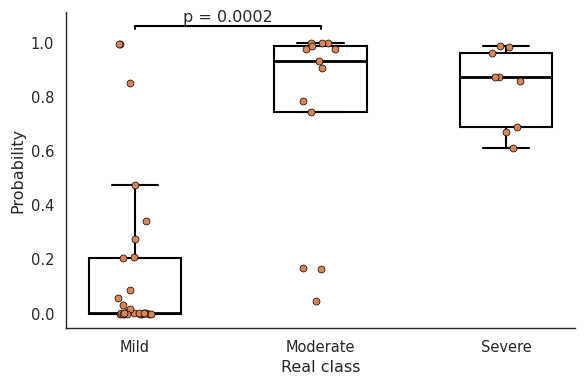

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(
    style="white",
    context="paper",
    font_scale=1.2
)
plt.figure(figsize=(6, 4))

ax = sns.boxplot(
    data=df,
    x="y_true",
    y="prob_1",
    showfliers=False, 
    width=0.5,
    showcaps=True,
    boxprops=dict(facecolor="white", edgecolor="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1.5),
    capprops=dict(color="black", linewidth=1.5),
    medianprops=dict(color="black", linewidth=2),
    flierprops=dict(marker='o', markerfacecolor='white',
                    markeredgecolor='black', markersize=6)
)
sns.stripplot(
    data=df,
    x="y_true",
    y="prob_1",
    jitter=True,
    size=5,
    edgecolor="black",
    linewidth=0.5
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([ "Mild","Moderate", "Severe"])

ax.set_xlabel("Real class")
ax.set_ylabel("Probability")
y = df["prob_1"].max() + 0.05

ax.plot([0, 0, 1, 1], [y, y+0.01, y+0.01, y], lw=1.5, c="black")
ax.text(0.5, y+0.015, "p = 0.0002", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("boxplot_prob_clase1.png", dpi=300)
plt.show()


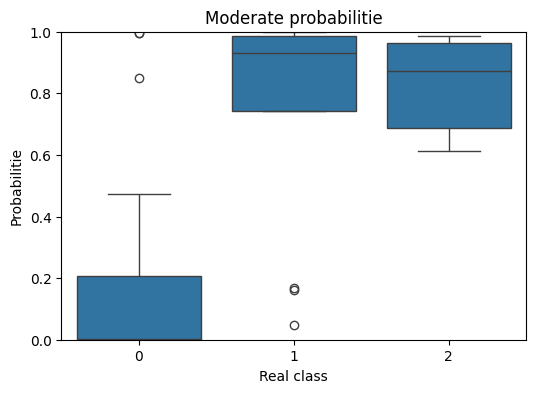

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(
    style="white",
    context="paper",
    font_scale=1.2
)

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="y_true",
    y="prob_1",
    order=[0, 1, 2]
)
plt.title("Moderate probabilitie")
plt.xlabel("Real class")
plt.ylabel("Probabilitie")
plt.ylim(0, 1)
plt.show()
plt.tight_layout()
plt.savefig("boxplot_prob_clase1.png", dpi=300)
plt.show()

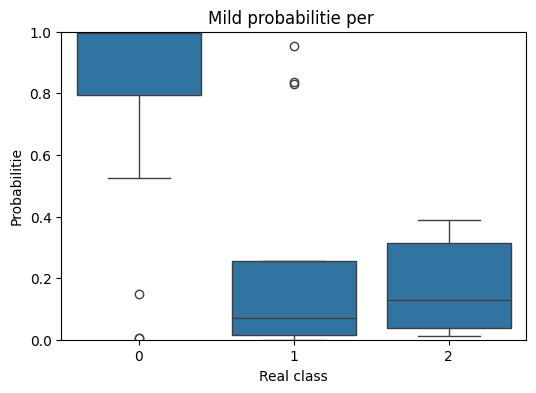

<Figure size 640x480 with 0 Axes>

In [41]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="y_true",
    y="prob_0",
    order=[0, 1, 2]
)
plt.title("Mild probabilitie per ")
plt.xlabel("Real class")
plt.ylabel("Probabilitie")
plt.ylim(0, 1)
plt.show()
plt.tight_layout()
plt.savefig("boxplot_prob_clase0.png", dpi=300)
plt.show()

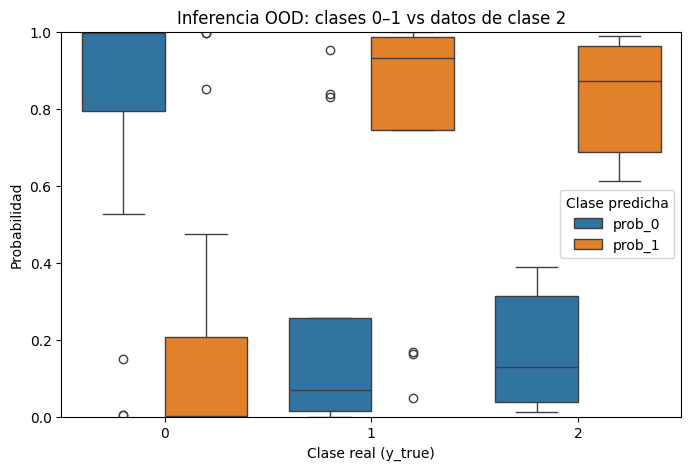

In [42]:
df_long = df.melt(
    id_vars="y_true",
    value_vars=["prob_0", "prob_1"],
    var_name="clase_predicha",
    value_name="probabilidad"
)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_long,
    x="y_true",
    y="probabilidad",
    hue="clase_predicha",
    order=[0, 1, 2]
)
plt.title("Inferencia OOD: clases 0–1 vs datos de clase 2")
plt.xlabel("Clase real (y_true)")
plt.ylabel("Probabilidad")
plt.ylim(0, 1)
plt.legend(title="Clase predicha")
plt.show()


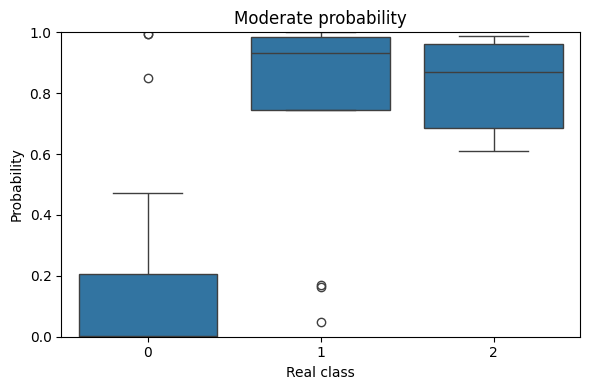

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="y_true",
    y="prob_1",
    order=[0, 1, 2]
)

plt.title("Moderate probability")
plt.xlabel("Real class")
plt.ylabel("Probability")
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("boxplot_prob_clase1.png", dpi=300)
plt.show()


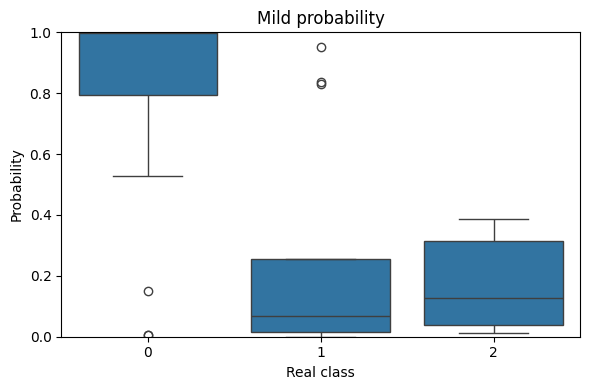

In [44]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="y_true",
    y="prob_0",
    order=[0, 1, 2]
)

plt.title("Mild probability")
plt.xlabel("Real class")
plt.ylabel("Probability")
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("boxplot_prob_clase0.png", dpi=300)
plt.show()
